In [1]:
!ls ./datasets/kaggle/

MMasseyOrdinals.csv		MNCAATourneySeeds.csv		  MTeams.csv
MNCAATourneyCompactResults.csv	MRegularSeasonCompactResults.csv


In [2]:
!ls ./datasets/torvik/mens/

team_2024.csv  top30_wins_2024.csv


In [3]:
import pandas as pd
import numpy as np

In [4]:
m_teams = pd.read_csv("./datasets/kaggle/MTeams.csv")
m_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025
3,1104,Alabama,1985,2025
4,1105,Alabama A&M,2000,2025


In [5]:
teamIDToName = {}
teamNameToID = {}

for row in range(m_teams.shape[0]):
    teamID = m_teams.iloc[row]["TeamID"].item()
    teamName = m_teams.iloc[row]["TeamName"]
    teamIDToName[teamID] = teamName
    teamNameToID[teamName] = teamID

In [6]:
m_massey_ordinals = pd.read_csv("./datasets/kaggle/MMasseyOrdinals.csv")
m_massey_ordinals[m_massey_ordinals["SystemName"] == "POM"].tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
5520900,2025,121,POM,1476,318
5520901,2025,121,POM,1477,330
5520902,2025,121,POM,1478,353
5520903,2025,121,POM,1479,342
5520904,2025,121,POM,1480,350


In [7]:
m_ncaa_regular_season = pd.read_csv("./datasets/kaggle/MRegularSeasonCompactResults.csv")
m_ncaa_regular_season[m_ncaa_regular_season["Season"] == 2024].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
181682,2024,0,1101,64,1329,59,A,0
181683,2024,0,1103,81,1355,75,A,0
181684,2024,0,1104,105,1287,73,H,0
181685,2024,0,1112,122,1288,59,H,0
181686,2024,0,1114,71,1402,66,H,0


In [8]:
m_ncaa_tourney_compact = pd.read_csv("./datasets/kaggle/MNCAATourneyCompactResults.csv")
m_ncaa_tourney_compact[m_ncaa_tourney_compact["Season"] == 2024].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2451,2024,134,1161,67,1438,42,N,0
2452,2024,134,1447,71,1224,68,N,0
2453,2024,135,1160,60,1129,53,N,0
2454,2024,135,1212,88,1286,81,N,0
2455,2024,136,1112,85,1253,65,N,0


In [9]:
m_ncaa_tourney_seeds = pd.read_csv("./datasets/kaggle/MNCAATourneySeeds.csv")
m_ncaa_tourney_seeds[m_ncaa_tourney_seeds["Season"] == 2024].head()

,Season,Seed,TeamID
2490,2024,W01,1163
2491,2024,W02,1235
2492,2024,W03,1228
2493,2024,W04,1120
2494,2024,W05,1361


In [10]:
# For each year Y: 
# For each team T that played in the tournament in year Y (ignore teams eliminated in play-in round):
# Record the number of wins by team T in the tournament in year Y, and collect the covariates for OLRE model

# Covariates:
# winning percentage at the end of the regular season (WINPCT), get this from Torvik instead of Kaggle
# point differential at the end of the regular season (DIFF)
# wins above bubble (WAB)
# number of wins against teams rated in the Top 30 based on Torvik's ratings at the end of the regular season (TOP30WIN)

# Let's do this for mens in year 2024

year = 2024
tourney_seeds = m_ncaa_tourney_seeds[m_ncaa_tourney_seeds["Season"] == year].reset_index(drop=True)
tourney_compact = m_ncaa_tourney_compact[m_ncaa_tourney_compact["Season"] == year].reset_index(drop=True)

teamIDs_round_64 = []
teamNames_round_64 = []

for i in range(tourney_seeds.shape[0]):
    teamID = tourney_seeds.at[i, "TeamID"]
    seed = tourney_seeds.at[i, "Seed"]
    if len(seed) > 3:
        # competed in the play-in round
        # check if they made it past this round
        team_tournament_games_won = tourney_compact[lambda df: df["WTeamID"] == teamID]
        if team_tournament_games_won.shape[0] == 0:
            # this means the play-in team won zero games (i.e. didn't make it past play-in round)
            continue
            
    teamIDs_round_64.append(teamID)
    teamNames_round_64.append(m_teams[m_teams["TeamID"] == teamID].iloc[0]["TeamName"])

if len(teamIDs_round_64) != 64:
    raise Exception(f"Expected 64 team IDs, found {len(teamIDs_round_64)}")

if len(teamNames_round_64) != 64:
    raise Exception(f"Expected 64 team names, found {len(teamNames_round_64)}")

# For each of these 64 teams, compute how many games they won in the tournament (ignoring play-in games)
n_tournament_games_won = []
for teamID in teamIDs_round_64:
    # Tournament games won
    team_tournament_games_won = tourney_compact[lambda df: df["WTeamID"] == teamID]
    seed = tourney_seeds[tourney_seeds["TeamID"] == teamID].iloc[0]["Seed"]
    n_games_won = team_tournament_games_won.shape[0] - (0 if len(seed) == 3 else 1)
    n_tournament_games_won.append(n_games_won)  

n_tournament_games_won = np.array(n_tournament_games_won)
if n_tournament_games_won.sum() != 32 + 16 + 8 + 4 + 2 + 1:
    raise Exception(f"Expected total of {32 + 16 + 8 + 4 + 2 + 1} games won across all teams in the tournament, found {n_tournament_games_won.sum()}")

# For each of these 64 teams, compute point differential winning percentage
regular_season_point_differential = []
for teamID in teamIDs_round_64:
    w_games = m_ncaa_regular_season[lambda df: (df["Season"] == year) & (df["WTeamID"] == teamID)]
    l_games = m_ncaa_regular_season[lambda df: (df["Season"] == year) & (df["LTeamID"] == teamID)]
    total_point_differential = (w_games["WScore"] - w_games["LScore"]).sum() + (l_games["LScore"] - l_games["WScore"]).sum()
    regular_season_point_differential.append(total_point_differential)

m_ncaa_tourney_wins = pd.DataFrame(np.array([teamIDs_round_64, teamNames_round_64, n_tournament_games_won]).T, columns=["TeamID", "TeamName", "Tournament Wins"])
m_ncaa_tourney_wins.head()

,TeamID,TeamName,Tournament Wins
0,1163,Connecticut,6
1,1235,Iowa St,2
2,1228,Illinois,3
3,1120,Auburn,0
4,1361,San Diego St,2


In [11]:
m_torvik_team_2024 = pd.read_csv("./datasets/torvik/mens/team_2024.csv")
m_torvik_team_2024 = m_torvik_team_2024.dropna(axis=1, how="all")
# Add a winning percentage column
m_torvik_team_2024["Win%"] = 100.0 * m_torvik_team_2024["Wins"] / m_torvik_team_2024["Games Played"]
m_torvik_team_2024.iloc[0]

TeamName        UC Santa Barbara
ADJOE                 104.517757
ADJDE                 109.958647
BARTHAG                 0.358106
Record                     14–15
Wins                          14
Games Played                  29
EFG%                        53.3
EFGD%                       50.6
FTR                         39.7
FTRD                        31.0
TOR                         19.1
TORD                        14.3
ORB                         25.2
DRB                         26.6
Unnamed: 15                 68.5
2P%                         53.4
2P%D                        51.8
3P%                         35.4
3P%D                        32.1
Unnamed: 20                  7.9
Unnamed: 21                  7.1
Unnamed: 22                 50.0
Unnamed: 23                 45.9
3PR                         30.5
3PRD                        33.7
ADJ T.                      68.2
Unnamed: 30                 2024
WAB                   -10.710547
Unnamed: 35                 74.4
Unnamed: 3

In [12]:
m_torvik_top30_wins_2024 = pd.read_csv("./datasets/torvik/mens/top30_wins_2024.csv")
m_torvik_top30_wins_2024 = m_torvik_top30_wins_2024.dropna(axis=1, how="all")
m_torvik_top30_wins_2024.iloc[0]

TeamName        UC Santa Barbara
ADJOE                  93.135271
ADJDE                  98.203272
BARTHAG                 0.352208
Record                       0–1
Wins                           0
Games Played                   1
EFG%                        38.8
EFGD%                       56.6
FTR                         32.8
FTRD                        14.7
TOR                         25.0
TORD                        17.1
ORB                         23.1
DRB                         31.4
Unnamed: 15                 75.9
2P%                         43.9
2P%D                        60.9
3P%                         17.6
3P%D                        31.8
Unnamed: 20                  6.5
Unnamed: 21                 14.6
Unnamed: 22                 52.4
Unnamed: 23                 54.3
3PR                         29.3
3PRD                        32.4
ADJ T.                      70.4
Unnamed: 30                 2024
WAB                    -0.301852
Unnamed: 35                 84.2
Unnamed: 3

In [13]:
# Add the top 30 wins column to the torvik team dataset
m_torvik_top30_wins_2024.rename(columns={"Wins": "Top30Wins"}, inplace=True)
m_torvik_team_2024 = m_torvik_team_2024.merge(m_torvik_top30_wins_2024[["TeamName", "Top30Wins"]], how="left", on="TeamName")
m_torvik_team_2024.fillna({"Top30Wins": 0}, inplace=True) # teams that have zero games played against top 30 do not appear in the top 30 dataset
m_torvik_team_2024.iloc[0]

TeamName        UC Santa Barbara
ADJOE                 104.517757
ADJDE                 109.958647
BARTHAG                 0.358106
Record                     14–15
Wins                          14
Games Played                  29
EFG%                        53.3
EFGD%                       50.6
FTR                         39.7
FTRD                        31.0
TOR                         19.1
TORD                        14.3
ORB                         25.2
DRB                         26.6
Unnamed: 15                 68.5
2P%                         53.4
2P%D                        51.8
3P%                         35.4
3P%D                        32.1
Unnamed: 20                  7.9
Unnamed: 21                  7.1
Unnamed: 22                 50.0
Unnamed: 23                 45.9
3PR                         30.5
3PRD                        33.7
ADJ T.                      68.2
Unnamed: 30                 2024
WAB                   -10.710547
Unnamed: 35                 74.4
Unnamed: 3

In [14]:
# Iterate through all Torvik team names, and check if it exists in the Kaggle Teams dataset.
# If no match exists, find the match and populate the conversion map.
# After some thinking, I realize it's more efficient to check the names of teams in the tournament, not all D1 schools.

# torvikToKaggleTeamName = {
#     "Arkansas Pine Bluff": "Ark Pine Bluff",
#     "Central Michigan": "C Michigan",
#     "FIU": "Florida Intl",
#     "Illinois Chicago": "IL Chicago",
#     "Florida Atlantic": "FL Atlantic",
#     "Cal St. Northridge": "CS Northridge",
#     "Abilene Christian": "Abilene Chr",
#     "UMKC": "Missouri KC",
#     "Northern Illinois": "N Illinois",
#     "Kent St": "Kent",
#     "Central Arkansas": "Cent Arkansas",
#     "American": "American Univ",
#     "UTSA": "UT San Antonio",
#     "Prairie View A&M": "Prairie View",
#     "Georgia Southern": "Ga Southern",
#     "Tennessee Martin": "TN Martin",
#     "LIU": "LIU Brooklyn",
#     "Loyola Chicago": "Loyola-Chicago",
#     "Maryland Eastern Shore": "MD E Shore",
#     "Fairleigh Dickinson": "F Dickinson",
#     "Queens": "Queens NC",
#     "Nebraska Omaha": "NE Omaha",
# }

In [15]:
# Go through all Torvik team names, make sure we can match them with the team names in the Kaggle dataset
kaggleToTorvikTeamNames = {
    "FL Atlantic": "Florida Atlantic",
    "St Mary's CA": "Saint Mary's",
    "Col Charleston": "Charleston",
    "S Dakota St": "South Dakota St.",
    "Grambling": "Grambling St.",
    "NC State": "North Carolina",
    "WKU": "Western Kentucky",
}

def preprocess_torvik_dataframe(torvik_df):
    torvik_teams = torvik_df["TeamName"]
    matches_torvik_teamName = lambda kaggle_teamName: ((torvik_teams == kaggle_teamName).sum().item() == 1)
    
    def mutate_torvik_teamName(old, new):
        torvik_df.loc[torvik_df["TeamName"] == old, "TeamName"] = new
        assert torvik_df.loc[torvik_df["TeamName"] == new].shape[0] == 1
    
    for kaggle_teamName in teamNames_round_64:
        if matches_torvik_teamName(kaggle_teamName):
            continue
            
        if kaggle_teamName.startswith("St "):
            test_teamName = "Saint" + kaggle_teamName[kaggle_teamName.index("St") + len("St"):]
            print(f"No match for '{kaggle_teamName}'\t checking if '{test_teamName}' exists")
            if matches_torvik_teamName(test_teamName):
                print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                mutate_torvik_teamName(test_teamName, kaggle_teamName)
                continue
                
        if kaggle_teamName.endswith("St"):
            # Looks like Kaggle uses St, while Torvid uses St.
            # We'll just remove the period at the end
            test_teamName = kaggle_teamName + "."
            print(f"No match for '{kaggle_teamName}'\t checking if '{test_teamName}' exists")
            if matches_torvik_teamName(test_teamName):
                print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                mutate_torvik_teamName(test_teamName, kaggle_teamName)
                continue
                
        if teamName.startswith("S "):
            # Looks like Kaggle uses S, while Torvid uses South
            test_teamName = "South" + kaggle_teamName[kaggle_teamName.index("South") + len("South"):]
            print(f"No match for '{kaggle_teamName}'\t checking if '{test_teamName}' exists")
            if matches_torvik_teamName(test_teamName):
                print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                mutate_torvik_teamName(test_teamName, kaggle_teamName)
                continue

        if kaggle_teamName in kaggleToTorvikTeamNames:
            print(f"Manual override for '{kaggleToTorvikTeamNames[kaggle_teamName]}' -> '{kaggle_teamName}'")
            torvik_team = torvik_teams[torvik_teams == kaggleToTorvikTeamNames[kaggle_teamName]]
            if torvik_team.shape[0] != 1:
                raise Exception(f"Expected matching Torvik team name in dataframe as dictionary is populated with key {kaggle_teamName}")
                mutate_torvik_teamName(kaggleToTorvikTeamNames[kaggle_teamName], kaggle_teamName)
            continue
        
        similar = torvik_teams[torvik_teams.str.startswith(kaggle_teamName[0])]
        raise Exception(f"No team name conversion found for Kaggle team name '{kaggle_teamName}'\nThe following are Torvik team names that start with the same character\n{similar}")

In [16]:
preprocess_torvik_dataframe(m_torvik_team_2024)

No match for 'Iowa St'	 checking if 'Iowa St.' exists
Mutating Torvik dataframe team name from 'Iowa St.' -> 'Iowa St'
No match for 'San Diego St'	 checking if 'San Diego St.' exists
Mutating Torvik dataframe team name from 'San Diego St.' -> 'San Diego St'
No match for 'Washington St'	 checking if 'Washington St.' exists
Mutating Torvik dataframe team name from 'Washington St.' -> 'Washington St'
Manual override for 'Florida Atlantic' -> 'FL Atlantic'
No match for 'Morehead St'	 checking if 'Morehead St.' exists
Mutating Torvik dataframe team name from 'Morehead St.' -> 'Morehead St'
No match for 'S Dakota St'	 checking if 'S Dakota St.' exists
Manual override for 'South Dakota St.' -> 'S Dakota St'
No match for 'St Mary's CA'	 checking if 'Saint Mary's CA' exists
Manual override for 'Saint Mary's' -> 'St Mary's CA'
No match for 'Mississippi St'	 checking if 'Mississippi St.' exists
Mutating Torvik dataframe team name from 'Mississippi St.' -> 'Mississippi St'
No match for 'Michigan S

In [17]:
Xy_ORLE = m_torvik_team_2024.merge(m_ncaa_tourney_wins, on="TeamName", how="right")
if Xy_ORLE.shape[0] != 64:
    raise Exception(f"Expected 64 rows in dataframe (one for each team). Found {Xy_ORLE.shape[0]} rows.")
    
Xy_ORLE = Xy_ORLE.merge(pd.DataFrame(np.array([teamNames_round_64, regular_season_point_differential]).T, columns=["TeamName", "PointDIFF"]), on="TeamName", how="inner")
Xy_ORLE = Xy_ORLE[["TeamName", "Win%", "PointDIFF", "WAB", "Top30Wins"]]
Xy_ORLE = m_ncaa_tourney_wins[["TeamName", "Tournament Wins"]].merge(Xy_ORLE, how="inner", on="TeamName")

if Xy_ORLE.shape[0] != 64:
    raise Exception(f"Expected 64 rows in dataframe (one for each team). Found {Xy_ORLE.shape[0]} rows.")

In [18]:
Xy_ORLE.head()

,TeamName,Tournament Wins,Win%,PointDIFF,WAB,Top30Wins
0,Connecticut,6,91.176471,580,11.237196,11.0
1,Iowa St,2,79.411765,485,6.274264,6.0
2,Illinois,3,76.470588,361,5.556308,5.0
3,Auburn,0,79.411765,520,5.211373,2.0
4,San Diego St,2,68.750000,219,2.171140,2.0


In [19]:
Xy_ORLE.to_csv("./datasets/Xy_ORLE.csv")

In [21]:
import matplotlib.pyplot as plt

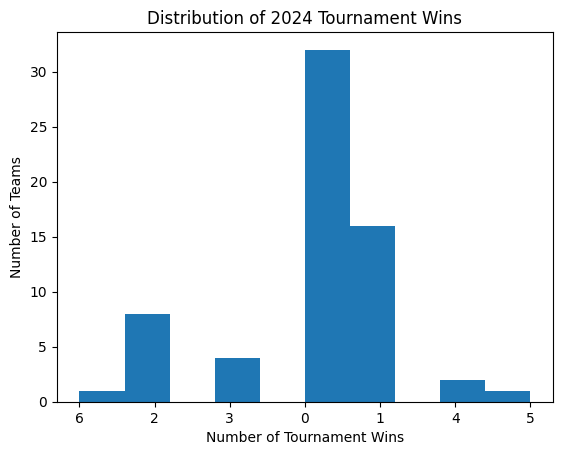

In [46]:
plt.hist(Xy_ORLE["Tournament Wins"])
plt.title("Distribution of 2024 Tournament Wins")
plt.ylabel("Number of Teams")
plt.xlabel("Number of Tournament Wins")
plt.savefig("./images/distribution-2024-tournament-wins.png")

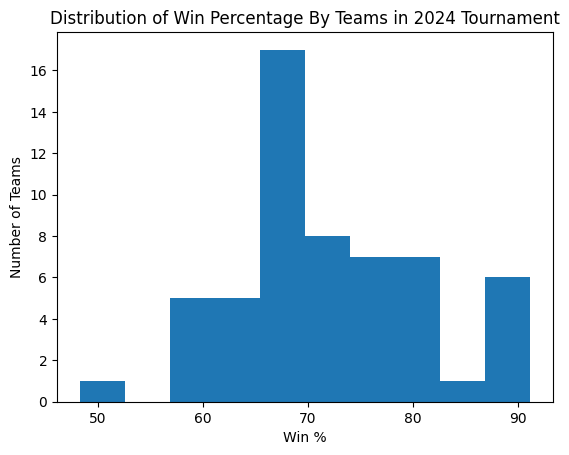

In [47]:
plt.hist(Xy_ORLE["Win%"], bins=10)
plt.title("Distribution of Win Percentage By Teams in 2024 Tournament")
plt.ylabel("Number of Teams")
plt.xlabel("Win %")
plt.savefig("./images/distribution-2024-win-percentage.png")

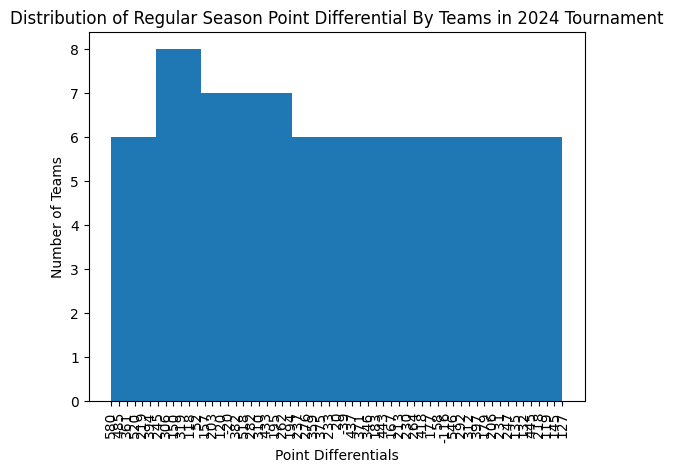

In [53]:
plt.hist(Xy_ORLE["PointDIFF"], bins=10)
plt.title("Distribution of Regular Season Point Differential By Teams in 2024 Tournament")
plt.ylabel("Number of Teams")
plt.xlabel("Point Differentials")
plt.xticks(rotation=90)
plt.savefig("./images/distribution-2024-point-differentials.png")

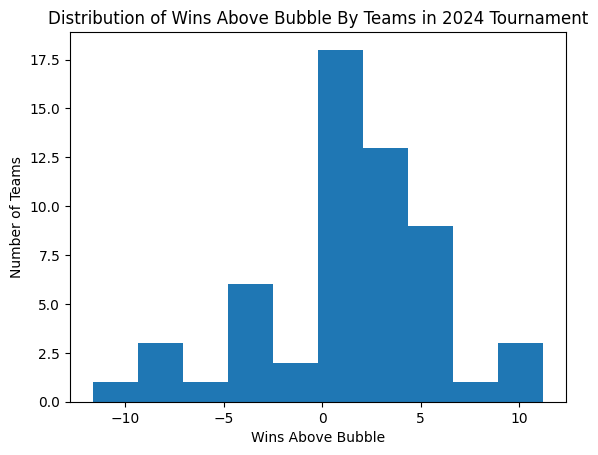

In [51]:
plt.hist(Xy_ORLE["WAB"])
plt.title("Distribution of Wins Above Bubble By Teams in 2024 Tournament")
plt.ylabel("Number of Teams")
plt.xlabel("Wins Above Bubble")
plt.savefig("./images/distribution-2024-wins-above-bubble.png")

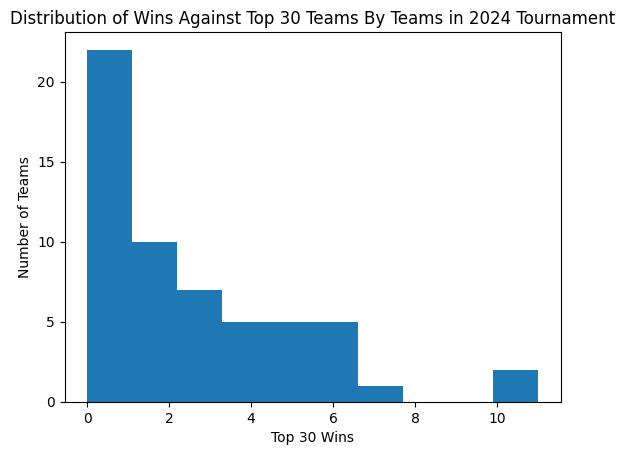

In [52]:
plt.hist(Xy_ORLE["Top30Wins"])
plt.title("Distribution of Wins Against Top 30 Teams By Teams in 2024 Tournament")
plt.ylabel("Number of Teams")
plt.xlabel("Top 30 Wins")
plt.savefig("./images/distribution-2024-top-30-wins.png")